<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/neutrons-background-2/tutorials/He3-Background-Characterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/neutrons-background-2/tutorials/He3-Background-Characterization.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Helium-3 Detector Background Characterization

### Prequel - What's a Helium-3 detector ?


Helium-3 (³He) detectors are gas-filled proportional counters widely used for detecting thermal neutrons. When a thermal neutron enters the detector, it interacts with a ³He nucleus via the reaction:

$$
n + {}^3\text{He} \rightarrow p + {}^3\text{H} + 764\,\text{keV}
$$

This reaction produces a proton and a triton (³H), which ionize the surrounding gas. The resulting charge is collected by an anode wire, and the induced current is amplified to produce a measurable signal. The signal amplitude is proportional to the energy deposited and provides a clear signature of neutron interactions.

## Helium-3 Tube Detectors – December 2024 / January 2025

Our goal is to characterize the background radiation detected by the Helium-3 neutron counters. To achieve this, we operated the detectors continuously throughout December 2024 and January 2025 in a stable background environment. In this notebook, we analyze the time-resolved background count data to establish a baseline response. In this analysis, we are interested in identifying statistically significant deviations in future experiments involving neutron-producing sources.


In [ ]:
# RUN THIS IF YOU ARE USING GOOGLE COLAB
import sys
import os
!git clone https://github.com/project-ida/arpa-e-experiments.git
sys.path.insert(0,'/content/arpa-e-experiments')
os.chdir('/content/arpa-e-experiments')

Cloning into 'arpa-e-experiments'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 255 (delta 132), reused 138 (delta 54), pack-reused 0 (from 0)
Receiving objects: 100% (255/255), 27.80 MiB | 8.48 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Updating files: 100% (54/54), done.


In [ ]:
# Libraries and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import poisson

import ipywidgets as widgets
from IPython.display import display

from IPython.display import Image
from IPython.display import Video
from IPython.display import HTML

# Use our custom helper functions
# - process_data
# - plot_panels
# - plot_panels_with_scatter
# - print_info
from libs.helpers import *

## Step 1 – Data Collection

Let’s begin by collecting raw data from the Helium-3 neutron detectors.

We have collected long-term time-resolved background data using our Helium-3 detectors, covering the period from December 14th, 2024 at 00:01:01 to January 23rd, 2025 at 23:58:59. These data consist of neutron counts recorded at regular time intervals.

We store the data as pandas DataFrames, which allows us to easily manipulate, visualize, and analyze the results in the steps that follow.

In [ ]:
he3_dec = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-background2-2.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

he3_jan = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-background-2.csv',
    #'https://lenr.mit.edu/call-rscript.php?filename=he3-detectors-background&graphno=2f&database=experiments&random=41',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

# To facilitate our analysis, let's concatenate december and january
he3_all = pd.concat([he3_dec, he3_jan])
he3_all = he3_all.sort_index()


## Step 2 - Visualizing Neutron and Gamma counts

Now that we have collected the raw data (i.e. electric signal history) that interests us, let us have a look at the measured neutron and gamma counts.

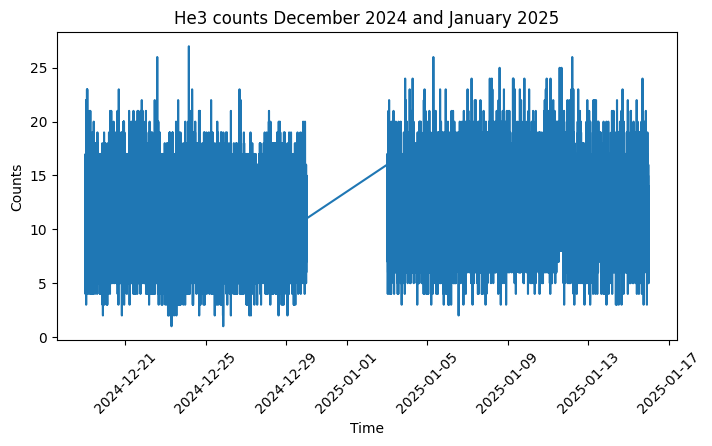

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(he3_all['Counts ch50-1000'])
plt.xlabel('Time')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title(f"He3 counts December 2024 and January 2025")
plt.show()
# plt.savefig("He3-counts-dec.png", dpi=600)

In [ ]:
he3_all['Counts ch50-1000'].describe()

,Counts ch50-1000
count,19478.000000
mean,11.189239
std,3.434293
min,1.000000
25%,9.000000
50%,11.000000
75%,13.000000
max,27.000000


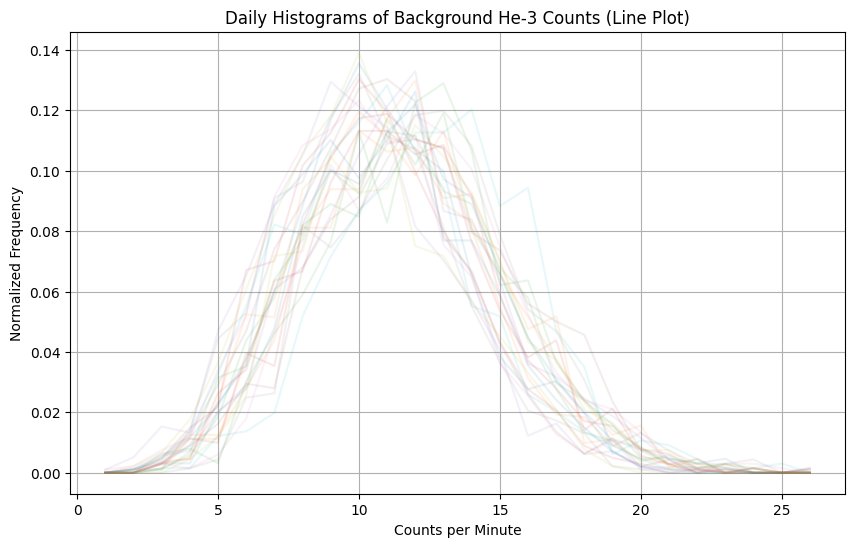

In [ ]:
# Ensure the index is datetime
he3_all.index = pd.to_datetime(he3_all.index)

# Group by day
grouped_by_day = he3_all.groupby(he3_all.index.date)

# Define bins for the histogram
bins = np.arange(he3_all['Counts ch50-1000'].min(), he3_all['Counts ch50-1000'].max() + 1, 1)  # Use integer bins

# Plot all histograms as line plots
plt.figure(figsize=(10, 6))

for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group['Counts ch50-1000'], bins=bins, density=True)
    plt.plot(bin_edges[:-1], hist_values, alpha=0.1, label=str(day))

plt.xlabel("Counts per Minute")
plt.ylabel("Normalized Frequency")
plt.title("Daily Histograms of Background He-3 Counts (Line Plot)")
plt.grid(True)
plt.show()


From the plot above, it is unclear whether the background ditribution corresponds to a Poisson ditribution with a large $\lambda$ or a Gaussian distribution. Let us begin by attempting to fit the data to a Poisson distribution.

In [ ]:
he3_all.index = pd.to_datetime(he3_all.index)

grouped_by_day = he3_all.groupby(he3_all.index.date)

bins = np.arange(he3_all["Counts ch50-1000"].min(),
                 he3_all["Counts ch50-1000"].max() + 1, 1)

# Compute daily histograms
histograms = []
for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group["Counts ch50-1000"], bins=bins, density=True)
    histograms.append(hist_values)

histograms = np.array(histograms)
mean_histogram = np.mean(histograms, axis=0)
std_histogram = np.std(histograms, axis=0)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit a normal distribution to the mean histogram (via expanded sample)
expanded_data = np.repeat(bin_centers, (mean_histogram * 1000).astype(int))
mu, sigma = norm.fit(expanded_data)
x = np.linspace(bin_centers.min(), bin_centers.max(), 500)
normal_pdf = norm.pdf(x, mu, sigma)
normal_pdf *= np.trapz(mean_histogram, bin_centers)

# Function to plot with Z-sigma band
def plot_with_z_band(Z):
    lower = np.maximum(mean_histogram - Z * std_histogram, 0)
    upper = mean_histogram + Z * std_histogram

    plt.figure(figsize=(10, 6))

    # Plot individual daily histograms
    for hist in histograms:
        plt.plot(bin_centers, hist, alpha=0.1, color='gray')

    # Plot mean histogram and normal fit
    plt.plot(bin_centers, mean_histogram, color='black', linewidth=2, label='Mean Daily Histogram')
    plt.plot(x, normal_pdf, 'r--', linewidth=2, label=f'Normal Fit (μ={mu:.2f}, σ={sigma:.2f})')

    # Plot Z-sigma band
    plt.fill_between(bin_centers, lower, upper, color='blue', alpha=0.2, label=f'±{Z}σ Band')

    # Labels and formatting
    plt.xlabel("Counts per Minute (ch50–1000)")
    plt.ylabel("Normalized Frequency")
    plt.title(f"He-3 Background Daily Histograms with ±{Z}σ Band")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create Z-score slider
z_slider = widgets.IntSlider(value=3, min=1, max=5, step=1, description='Z-score:', continuous_update=False)

# Interactive output
interactive_plot = widgets.interactive_output(plot_with_z_band, {'Z': z_slider})

# Display
display(z_slider, interactive_plot)


In [ ]:
# Ensure datetime index
he3_all.index = pd.to_datetime(he3_all.index)

# Group by day
grouped_by_day = he3_all.groupby(he3_all.index.date)

# Define bins
bins = np.arange(he3_all["Counts ch50-1000"].min(),
                 he3_all["Counts ch50-1000"].max() + 1, 1)

# Compute daily histograms
histograms = []
for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group["Counts ch50-1000"], bins=bins, density=True)
    histograms.append(hist_values)

# Convert list to array and compute mean + std
histograms = np.array(histograms)
mean_histogram = np.mean(histograms, axis=0)
std_histogram = np.std(histograms, axis=0)
k_values = bin_edges[:-1]

# Estimate Poisson background mean
lambda_ = he3_all["Counts ch50-1000"].mean()

# Poisson fit
poisson_pmf = stats.poisson.pmf(k_values, mu=lambda_)
poisson_pmf_normalized = poisson_pmf / np.sum(poisson_pmf)
poisson_pmf_normalized *= np.sum(mean_histogram)

# Interactive plot function
def plot_histogram_with_z(Z):
    upper = mean_histogram + Z * std_histogram
    lower = np.maximum(mean_histogram - Z * std_histogram, 0)

    plt.figure(figsize=(10, 6))

    # Daily histograms
    for hist in histograms:
        plt.plot(k_values, hist, alpha=0.2, color='gray')

    # Mean histogram
    plt.plot(k_values, mean_histogram, color='black', linewidth=2, label='Mean Histogram')

    # Z-sigma band
    plt.fill_between(k_values, lower, upper, color='black', alpha=0.1, label=f'±{Z}σ Band')

    # Poisson fit
    plt.plot(k_values, poisson_pmf_normalized, 'r--', linewidth=2, label=f'Poisson Fit (λ={lambda_:.2f})')

    # Labels and formatting
    plt.xlabel("Counts per Minute (ch50–1000)")
    plt.ylabel("Normalized Frequency")
    plt.title(f"He-3 Daily Histograms with ±{Z}σ Band and Poisson Fit")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Z-score slider
z_slider = widgets.IntSlider(value=3, min=1, max=5, step=1, description='Z-score:', continuous_update=False)

# Display
interactive_plot = widgets.interactive_output(plot_histogram_with_z, {'Z': z_slider})
display(z_slider, interactive_plot)


Ultimately, it is hard to differentiate between these by eye. This might be a result of the central limit theorem ? I think we expect that with a biigger $\lambda$, our Poisson distribution would tend to a normal distribution.

In [ ]:
# Estimate Poisson mean for He-3 data
lambda_he3 = he3_all["Counts ch50-1000"].mean()

# Define the interactive plotting function
def plot_he3_outliers(Z):
    # Calculate the Z-score-based Poisson threshold
    threshold_poisson = lambda_he3 + Z * np.sqrt(lambda_he3)

    # Filter for outliers
    poisson_outliers = he3_all[he3_all["Counts ch50-1000"] > threshold_poisson]

    # Plot the time series and outliers
    plt.figure(figsize=(14, 5))
    plt.plot(he3_all.index, he3_all["Counts ch50-1000"],
             label="He-3 Counts per Minute", color='green', linewidth=1)

    plt.scatter(poisson_outliers.index, poisson_outliers["Counts ch50-1000"],
                color='red', label=f"{len(poisson_outliers)} Outliers (> {threshold_poisson:.2f})", zorder=5)

    plt.axhline(threshold_poisson, color='gray', linestyle='--', linewidth=1.5,
                label=f"Z = {Z} Threshold")

    plt.title(f"He-3 Count Time Series with Z={Z} Outlier Threshold")
    plt.xlabel("Time")
    plt.ylabel("Counts per Minute (ch50–1000)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create the Z-score slider
z_slider_he3 = widgets.IntSlider(value=3, min=1, max=10, step=1,
                                 description='Z-score:', continuous_update=False)

# Connect slider to plotting function
interactive_plot_he3 = widgets.interactive_output(plot_he3_outliers, {'Z': z_slider_he3})

# Display slider and plot
display(z_slider_he3, interactive_plot_he3)
